<a href="https://colab.research.google.com/github/Fyllx/CFT_test/blob/master/CFT_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading the data

In [1]:
from os.path import join
from google.colab import drive
VM_DRIVE_FOLDER = join('/content', 'gdrive')
drive.mount(VM_DRIVE_FOLDER)
MY_DRIVE = join(VM_DRIVE_FOLDER, 'My Drive')
CFT_DATA = join(MY_DRIVE, 'DATA', 'CFT')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [119]:
!ls -l --block-size=M '$CFT_DATA'

total 382M
-rw------- 1 root root  21M Jun 22 12:31 bottom100.joblib
-r-------- 1 root root   9M Mar 25 12:17 kinopoisk_bottom100.zip
-r-------- 1 root root  44M Mar 25 12:17 kinopoisk_top250.zip
-rw------- 1 root root   1M Jun 23 15:03 metrics_cossim.joblib
-rw------- 1 root root   1M Jun 23 20:20 metrics_mlpc.joblib
-rw------- 1 root root 154M Jun 22 15:23 new_texts.joblib
-rw------- 1 root root 108M Jun 22 12:28 top250.joblib
-rw------- 1 root root  49M Jun 23 16:21 X_reduced.joblib


In [0]:
from IPython.display import HTML, display

def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

In [0]:
import zipfile
import chardet
import unicodedata
import xml.etree.ElementTree as ET
from joblib import dump, load

In [0]:
def extract_data(zfile):
  all_texts = []
  compatible_encodings = ['maccyrillic', 'windows-1251']
  compatible_name_encodings = ['ascii', 'ibm866', 'windows-1253', 'windows-1252']

  N = len(zfile.namelist())
  out = display(progress(0, N), display_id=True)
  for i, name in enumerate(zfile.namelist()):
    out.update(progress(i, N))

    if '.xml' not in name:
      continue
    film_name_encoded = name.split('/')[-2].encode('cp437')
    film_name_encoding = chardet.detect(film_name_encoded)['encoding']
    film_name = film_name_encoded.decode('IBM866')
    try:
      assert film_name_encoding.lower() in compatible_name_encodings, \
              'Invalid film name encoding: {};\n Name: {}'.format(film_name_encoding, film_name)
    except Exception:
      print(name)
      print(film_name_encoding)
      print(film_name)

    data = zfile.read(name)
    chd = chardet.detect(data)
    encoding = chd['encoding']
    str_repr = unicodedata.normalize("NFKC", data.decode('windows-1251'))
    try:
      assert encoding.lower() in compatible_encodings, \
              'Invalid text encoding: {};\n Text: {}'.format(str_repr)
    except Exception:
      print(str_repr)
      print(chd)
    root = ET.fromstring(str_repr)
    new_text = dict()
    new_text['text'] = root.find('content').text
    new_text['grade3'] = root.find('grade3').text
    new_text['grade10'] = root.find('grade10').text
    new_text['date'] = root.find('date').text
    new_text['film_name'] = film_name
    all_texts.append(new_text)
  return all_texts

In [0]:
# !rm '$CFT_DATA/top250.joblib'
# !rm '$CFT_DATA/bottom100.joblib'

In [7]:
def cached_extract(template):
  result = []
  try:
    result = load(join(CFT_DATA, '{}.joblib'.format(template)))
  except Exception:
    file = join(CFT_DATA, 'kinopoisk_{}.zip'.format(template))
    with zipfile.ZipFile(file, 'r') as archive:
      result = extract_data(archive)
    dump(result, join(CFT_DATA, '{}.joblib'.format(template)))
  return result

print('loading top250 films\' reviews')
all_reviews = cached_extract('top250')
print('loading bottom100 films\' reviews')
all_reviews.extend(cached_extract('bottom100'))

loading top250 films' reviews
loading bottom100 films' reviews


In [8]:
print(len(all_reviews))

36591


## Problem description

The dataset consist of 36591 film reviews, written in Russian for 350 different films.

The task at hand is to learn to distinguish, given the pair of reviews, wether or not this pair is about the same movie.

We are free to choose metrics, sampling process and any other methodological details.

In [0]:
import pandas as pd
df = pd.DataFrame(all_reviews)

# Text preprocessing

In [10]:
!pip install pymorphy2

In [11]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
russian_stopwords = stopwords.words("russian")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
def tokenize(arg):
  return tokenizer.tokenize(arg)

In [0]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()
def normal_form(word):
  return morph.parse(word)[0].normal_form

In [0]:
def preprocess_text(text):
  text = tokenize(text)
  text = [normal_form(word) for word in text]
  text = [word for word in text if word not in russian_stopwords]
  return text

In [0]:
new_texts_file = join(CFT_DATA, 'new_texts.joblib')
# !rm '$new_texts_file'
try:
  new_texts = load(new_texts_file)
except Exception:
  N = df.text.shape[0]
  out = display(progress(0, N), display_id=True)
  new_texts = []
  for i in range(N):
    out.update(progress(i, N))
    txt = df.text.iloc[i]
    new_texts.append(preprocess_text(txt))
  dump(new_texts, new_texts_file)
new_texts = pd.Series(new_texts)

# TF-IDF features and baseline algorithms

In [0]:
#TODO: feature idea: number of words in text that match words in names

In [0]:
names_to_labels = {'UNKNOWN':0}
labels_to_names = {0:'UNKNOWN'}
for i, name in enumerate(df.film_name.unique()):
  names_to_labels[name] = i+1
  labels_to_names[i+1] = name
labels = df.film_name.transform(lambda name: names_to_labels.get(name, 0))

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
#could be more fair to fit only on X_train
X = vectorizer.fit_transform(new_texts.transform(lambda arr: " ".join(arr)))
Y = labels

## Films separability

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)
#TODO: try other models for this section

In [20]:
from sklearn.ensemble import RandomForestClassifier

#Warning! Heavy on memory and calculations
rf = RandomForestClassifier(n_estimators=300, max_depth=110, oob_score=True)
rf.fit(X_train, Y_train)
#Trained model weights around 6Gb, so there's no use dump/load'ing it
print("Number of classes: {}".format(labels.max()))
print("Accuracy (oob_score):", rf.oob_score_)
print("Accuracy (test): ", rf.score(X_test, Y_test))

Number of classes: 350
Accuracy (oob_score): 0.7726935540545816
Accuracy (train/test):  0.781198761158681


Accuracy of 77-79% for 350 classes is very good! We can work with these features.

If we were to use these predictions for our final task - classifying pairs of reviews, we would get 0.78^2 **~ 0.6 recall** on binary classification with around 350*(1/350)^2 ~ 0,008 class disbalance, which is not bad at all. But that's theoretical figures, let's verify this.

In [21]:
total_films = Y.shape[0]
true_count = 0
false_count = 0
for n in Y.value_counts():
  true_count += (-n + n*n)
  false_count += n * (total_films - n)
true_count /= 2
false_count /= 2
print('True count:', int(true_count))
print('False count:', int(false_count))
print('Class disbalance in all data:', 2*true_count/(-total_films + total_films*total_films) )

True count: 5392026.0
False count: 664040319.0
Class disbalance in all data: 0.008054624250341534


In [0]:
import numpy as np

preds = rf.predict(X_test)

In [23]:
print('Total data points:', preds.shape[0]**2)
N = int(1e7)
print('Conducting an experiment on a {} randomly sampled points ({:.4}%)'.format(N, 100*N / preds.shape[0]**2))
ind1 = np.random.uniform(0, Y_test.shape[0], N).astype('int64')
ind2 = np.random.uniform(0, Y_test.shape[0], N).astype('int64')

binary_Y = Y_test.values[ind1] == Y_test.values[ind2]
print('Class balance in test:', binary_Y.sum() / N)
binary_pred = preds[ind1] == preds[ind2]
print('Balance of predictions:', binary_pred.sum() / N)
print('Accuracy:', (binary_pred == binary_Y).sum() / N)
TPR = (binary_Y * binary_pred).sum() / binary_Y.sum()
print('Recall (TPR):', TPR)
PPV = (binary_Y * binary_pred).sum() / binary_pred.sum()
print('Precision:', PPV)
F1 = 2 * PPV*TPR / (PPV+TPR)
print('F1 score:', F1)
FPR = (binary_pred * (~binary_Y)).sum() / (~binary_Y).sum()
print('FPR:', FPR)

Total data points: 120516484
Conducting an experiment on a 10000000 randomly sampled points (8.298%)
Class balance in test: 0.0082168
Balance of predictions: 0.0138629
Accuracy: 0.9921347
Recall (TPR): 0.8649595949761464
Precision: 0.5126777225544439
F1 score: 0.643776862910275
FPR: 0.006811670131133498


Recall in experiments is even higher than theoretically predicted.

In general, that's a decent baseline method, but it has a lot of drawbacks:


1.   There's not much we can do to fine-tune TPR/FPR
2.   A lot of information is being lost when we make a strict prediction on each individual review - working with probability distributions and evaluating P(f1==f2|distr1,distr2) may yield much better results
3.  With such an approach we can't work with unknown films.



## Words importance

In [31]:
import matplotlib.pyplot as plt

feature_importances = rf.feature_importances_
imp = zip(vectorizer.get_feature_names(), feature_importances)
imp = sorted(imp, key=lambda x: -x[1])
imp = pd.DataFrame(imp)
imp.head(30)

,0,1
0,сон,0.005431
1,нолана,0.005050
2,амели,0.004422
3,хатико,0.004052
4,джокер,0.003712
5,шерлок,0.003702
6,холмс,0.003385
7,леджер,0.003366
8,собака,0.003196
9,дикаприо,0.003129


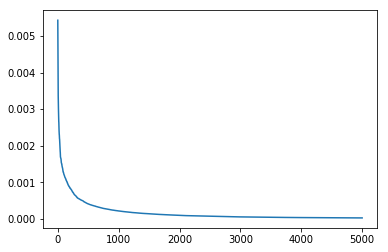

In [30]:
plt.plot(imp[1][:5000])

In [0]:
#TODO: collapse forms of important words that were not recognized by pymorph2
for i, txt in enumerate(new_texts):
  #'форрест'
  #'форресть'
  if 'форест' in txt:
    print("{}: {}".format(df.film_name.iloc[i], txt))

In [61]:
ind_imps = sorted([(i, imp) for i, imp in enumerate(feature_importances)], key=lambda x:-x[1])
reduced_indexes = [el[0] for el in ind_imps[:5000]]
#dimension reduction to try other methods

XR_file = join(CFT_DATA, 'X_reduced.joblib')
#!rm '$XR_file'
try:
  X_reduced = load(XR_file)
except Exception:
  X_reduced = X[:, reduced_indexes]
  dump(X_reduced, XR_file)

['/content/gdrive/My Drive/DATA/CFT/X_reduced.joblib']

In [0]:
del rf

## Cosine similarity

In [0]:
def predict_similarity(v1, v2, threshold=0.05):
  numer = (v1*v2.T).toarray()[0][0]
  denom = ( (v1*v1.T)*(v2*v2.T) ).toarray()[0][0]
  cossim = numer / denom
  return cossim > threshold

In [50]:
metrics_file = join(CFT_DATA, 'metrics_cossim.joblib')
# !rm '$metrics_file'
try:
  TPR, FPR, F1, thr = load(metrics_file)
except Exception:
  TPR = []
  FPR = []
  F1 = []
  thr = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.1, 0.13, 0.16, 0.2]
  for threshold in thr:
    N = int(6000)
    ind1 = np.random.uniform(0, Y.shape[0], N).astype('int64')
    ind2 = np.random.uniform(0, Y.shape[0], N).astype('int64')
    binary_Y = Y.values[ind1] == Y.values[ind2]

    binary_pred = []
    out = display(progress(0, ind1.shape[0]), display_id=True)
    count=0
    #TODO: vectorize the computation, it's SO slow right now
    for i1, i2 in zip(ind1, ind2):
      count+=1
      out.update(progress(count, ind1.shape[0]))
      binary_pred.append(predict_similarity(X[i1], X[i2], threshold))
    binary_pred = np.asarray(binary_pred)

    TPR.append( (binary_Y * binary_pred).sum() / binary_Y.sum() )
    print('Recall:', TPR[-1])
    PPV = (binary_Y * binary_pred).sum() / binary_pred.sum()
    print('Precision:', PPV)
    F1.append( 2 * PPV*TPR[-1] / (PPV+TPR[-1]) )
    print('F1:', F1[-1])
    FPR.append( (binary_pred * (~binary_Y)).sum() / (~binary_Y).sum())
    print('FPR:', FPR[-1])
  dump((TPR, FPR, F1, thr), metrics_file)

Recall: 1.0
Precision: 0.008529512111907198
F1: 0.016914749661705007
FPR: 0.9768067226890756


Recall: 0.9830508474576272
Precision: 0.010885885885885885
F1: 0.021533320957861517
FPR: 0.8870560511698368


Recall: 0.9636363636363636
Precision: 0.011988237955213752
F1: 0.023681858802502235
FPR: 0.7347350714886459


Recall: 0.9183673469387755
Precision: 0.013765677577240747
F1: 0.027124773960216998
FPR: 0.5417576877835658


Recall: 0.8909090909090909
Precision: 0.02106620808254514
F1: 0.041159176816463666
FPR: 0.38301093355761145


Recall: 0.8909090909090909
Precision: 0.032579787234042555
F1: 0.06286080821039128
FPR: 0.2447434819175778


Recall: 0.8837209302325582
Precision: 0.04357798165137615
F1: 0.08306010928961749
FPR: 0.14000335739466174


Recall: 0.7666666666666667
Precision: 0.08199643493761141
F1: 0.14814814814814817
FPR: 0.0867003367003367


Recall: 0.5740740740740741
Precision: 0.16489361702127658
F1: 0.256198347107438
FPR: 0.026404305415405314


Recall: 0.41379310344827586
Precision: 0.4528301886792453
F1: 0.4324324324324324
FPR: 0.004880511612251767


Recall: 0.3103448275862069
Precision: 0.8571428571428571
F1: 0.45569620253164556
FPR: 0.0005048805116122518


Recall: 0.1836734693877551
Precision: 0.8181818181818182
F1: 0.3
FPR: 0.0003360779700890607


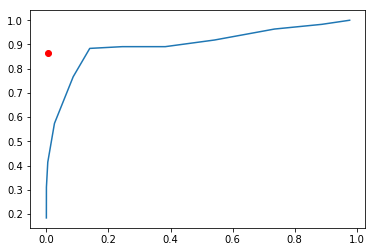

In [55]:
plt.plot(FPR, TPR)
plt.scatter(0.0065, 0.865, c='r') # random forest method

This approach solves two of the problems of the previous method:


1.   It gives us a way to choose TPR/FPR from a certain spectrum
2.   It doesn't really learn film labels, only the notion of similarity built in TF-IDF features, so it can be used for unseen films.

Unfortunately, it doesn't achieve 0.865/0.0065 TPF/FPR (or 0.64 F1 score), which shows that in general it's not that good.

# Multi-layer Perceptron classifier on reduced data

In [0]:
X_reduced = load(join(CFT_DATA, 'X_reduced.joblib'))

In [0]:
XR_train, XR_test, Y_train, Y_test = train_test_split(X_reduced, Y, test_size=0.3)

In [75]:
from sklearn.neural_network import MLPClassifier
mlpc = MLPClassifier((300), batch_size=500)#, verbose=True)
mlpc.fit(XR_train, Y_train)
print('Accuracy: ', mlpc.score(XR_test, Y_test))

Iteration 1, loss = 5.35209840
Iteration 2, loss = 4.35196202
Iteration 3, loss = 3.27578169
Iteration 4, loss = 2.34183791
Iteration 5, loss = 1.70847645
Iteration 6, loss = 1.30455977
Iteration 7, loss = 1.03540745
Iteration 8, loss = 0.84558985
Iteration 9, loss = 0.70237389
Iteration 10, loss = 0.59094841
Iteration 11, loss = 0.50120248
Iteration 12, loss = 0.42771817
Iteration 13, loss = 0.36772878
Iteration 14, loss = 0.31728763
Iteration 15, loss = 0.27434592
Iteration 16, loss = 0.23849750
Iteration 17, loss = 0.20741338
Iteration 18, loss = 0.18125563
Iteration 19, loss = 0.15834049
Iteration 20, loss = 0.13855495
Iteration 21, loss = 0.12199743
Iteration 22, loss = 0.10711279
Iteration 23, loss = 0.09452064
Iteration 24, loss = 0.08340549
Iteration 25, loss = 0.07418359
Iteration 26, loss = 0.06608524
Iteration 27, loss = 0.05905049
Iteration 28, loss = 0.05314781
Iteration 29, loss = 0.04792758
Iteration 30, loss = 0.04350001
Iteration 31, loss = 0.03969185
Iteration 32, los

A gain from 77% to 90% in accuracy of film prediction compared to random forest 

In [0]:
pred_prob = mlpc.predict_proba(XR_test)

In [107]:
TPR = []
FPR = []
F1 = []
thr = np.linspace(0.01, 0.99, 30) ** 3
for threshold in thr:
  N = int(1e6)
  ind1 = np.random.uniform(0, Y_test.shape[0], N).astype('int64')
  ind2 = np.random.uniform(0, Y_test.shape[0], N).astype('int64')
  binary_Y = Y_test.values[ind1] == Y_test.values[ind2]

  binary_pred = []
  for i in range(ind1.shape[0]):
    #proba = P(film1 == film2 | prediction1, prediction2)
    proba = pred_prob[ind1[i]].dot(pred_prob[ind2[i]])
    binary_pred.append(proba > threshold)
  binary_pred = np.asarray(binary_pred)

  TPR.append( (binary_Y * binary_pred).sum() / binary_Y.sum() )
  print('Recall:', TPR[-1])
  PPV = (binary_Y * binary_pred).sum() / binary_pred.sum()
  print('Precision:', PPV)
  F1.append( 2 * PPV*TPR[-1] / (PPV+TPR[-1]) )
  print('F1:', F1[-1])
  FPR.append( (binary_pred * (~binary_Y)).sum() / (~binary_Y).sum())
  print('FPR:', FPR[-1])
  dump((TPR, FPR, F1, thr), metrics_file)

Recall: 0.9998790517658442
Precision: 0.01633920400979522
F1: 0.03215299020475313
FPR: 0.5018432399075556
Recall: 0.9997544505831799
Precision: 0.03451374319198084
F1: 0.0667240249098656
FPR: 0.22966260189241372
Recall: 0.9982853643600735
Precision: 0.05951720310765816
F1: 0.11233694191583345
FPR: 0.12986131765868314
Recall: 0.9957606589147286
Precision: 0.098271492779956
F1: 0.17888850204543474
FPR: 0.07606297592927207
Recall: 0.9907851087357169
Precision: 0.1523061232198844
F1: 0.264025538184497
FPR: 0.045250292127626754
Recall: 0.986548162382897
Precision: 0.22877036624425567
F1: 0.37141371436322945
FPR: 0.027923490985949012
Recall: 0.9822076978939724
Precision: 0.31009973632924454
F1: 0.4713775376840638
FPR: 0.018204404792394765
Recall: 0.9736428485068311
Precision: 0.392197925290995
F1: 0.5591584502152479
FPR: 0.012584082950080113
Recall: 0.970703125
Precision: 0.47593966961934403
F1: 0.638714859437751
FPR: 0.008828321610634316
Recall: 0.963275135460566
Precision: 0.54395865914190

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in long_scalars


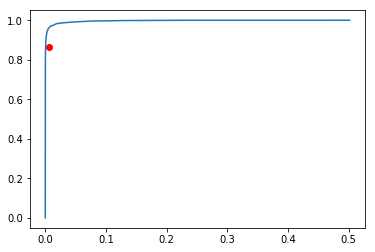

In [108]:
plt.plot(FPR, TPR)
plt.scatter(0.0065, 0.865, c='r') # random forest method

0.9005111582096995


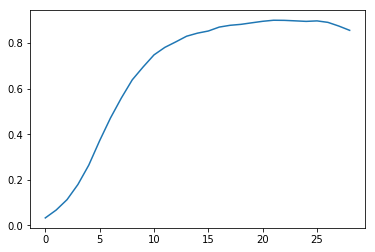

In [113]:
plt.plot(F1)
print(np.nanmax(F1))

A simple fully-connected neural network with 300 hidden neurons that predicts the movie (out of 350 possibilities) with 90% accuracy creates a great predictor for review pairs. It outperforms baseline solution and allows us to choose desirable TPR/FPR in a very good range of values.

However, it has its drawbacks.

*    For one, we can't guarantee a good performance on unseen films. It is possible to have decent performance with current architecture, but we need to test it further. The way to deal with this problem is to remove the final softmax layer and make a loss function to directly minimise distances between reviews of the same films, effectively making it a seamese neural network.
*   It is unclear how feature importances derived from a random forest affects the end solution
*   This architecture **still** treats documents as bags of words, losing one of the most important information sources in natural language: the order of the words 




# Future work

We might gain some performance by changing the ML models and tuning the hyperparameters in the existing pipeline.

We may also improve this pipeline - or degrade - by training the models end-to-end - directly on pairs of reviews and single-bit supervision (is it a matching pair or not). But this could be computationally expensive and may pose some difficult questions about the sampling process, as it's a very disbalanced population.

Probably the most interesting thing to try would be to move to sequential language models.

If we were to do that, first of all we would replace TF-IDF step with finding a good pretrained word embeddings (or training a new embeddings directly on a given dataset).
Then with these embeddings we would be able to do, for example, a stacked BLSTM to create document embeddings. The last step would be the same - either classification of the known films and then evaluation of a probability P(f1==f2), or a direct optimization of the distances between document embeddings.

Pipeline:


*   tokenize
*   stem/lemmatize
*   remove stop-words
*   TF-IDF                                                                                --> word embeddings
*   if possible, reduce the dimensions                               --> sequential model for document embeddings
*   classify individual reviews on known categories       <~~> classify pairs directly
*   on pairs - compare predictions for individual reviews and compare